
# Lesson 5 - Logistic Regression

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression,Ridge, LogisticRegression
import math
from scipy.special import expit
from sklearn.model_selection import train_test_split

/var/folders/rn/1nw_2xns2sd3snlx7_6tk_h80000gn/T/ipykernel_4341/830163652.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  table['Gender'] = table['Gender'].replace({'Female': 0, 'Male': 1}).astype(int)


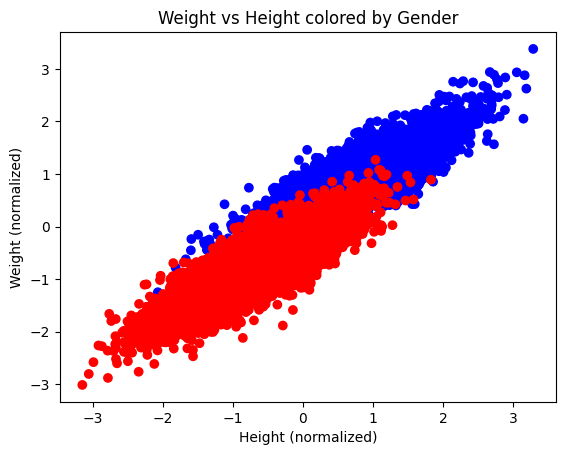

In [21]:
table = pd.read_csv('../../data/weight-height.csv')
table['Gender'] = table['Gender'].replace({'Female': 0, 'Male': 1}).astype(int)
X = table[['Height', 'Weight']]
y = table['Gender']

# Normalize X properly
X = (X - X.mean()) / X.std()
X = X.values
y = y.values

# plot

plt.scatter(X[:,0],X[:,1],c=y,cmap=matplotlib.colors.ListedColormap(['red','blue']))
plt.xlabel('Height (normalized)')
plt.ylabel('Weight (normalized)')
plt.title('Weight vs Height colored by Gender')
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#try with skleaarn logistic classifier
clf = LogisticRegression().fit(X_train, y_train)
score = clf.score(X_test,y_test)
print('score = ',score)
print('weights = ',clf.coef_[0])
print('intercept = ',clf.intercept_)

score =  0.9206060606060606
weights =  [-1.83414128  6.1642149 ]
intercept =  [-31.75842913]


In [12]:
clf.predict_proba(X_test)

array([[0.2376006 , 0.7623994 ],
       [0.00481685, 0.99518315],
       [0.1543731 , 0.8456269 ],
       ...,
       [0.995263  , 0.004737  ],
       [0.96848745, 0.03151255],
       [0.92048821, 0.07951179]], shape=(3300, 2))

In [13]:
clf.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0], shape=(3300,))

Sanity check: Let's generate the probability of `gender='male'` for the first `['Height','Weight']` example multiplying by the weights and then applying the sigmoid

In [15]:
from scipy.special import expit #sigmoid
weights = clf.coef_[0]
x = X_test[0]
print(weights)
print(x)
print(np.dot(x,weights) + clf.intercept_)
expit(np.dot(x,weights) + clf.intercept_ )

[-1.83414128  6.1642149 ]
[-11.75273726   1.84421345]
[1.16587944]


array([0.7623994])

> Note
> Why height has a negative weight in th regression if it correlates positive with male?

you should be wary of interpreting raw correlations when other important variables exist. If the positively-correlated regressor is the only regressor in a linear model then its coefficient should be positive. But if there are several regressors and, they are not independent it may not happen.

It also depends on the level of regularization applied (later on)

implementation from scratch

check our Logistic Regression slides from this lesson

In [22]:
def cost_function(X, y, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return (-1/X.shape[0]) * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def logistic_regression(features, target, num_steps, learning_rate):
    cost = []
    weights = np.zeros(features.shape[1])

    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = expit(scores)

        # Clip predictions to avoid log(0)
        predictions = np.clip(predictions, 1e-15, 1 - 1e-15)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = 2/features.shape[0] * np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        cost.append(cost_function(features, target, predictions))

    return weights, cost


weights =  [ 2.02701002 17.3053036 ]
test cost =  0.5232466227773097
score =  0.9015151515151515


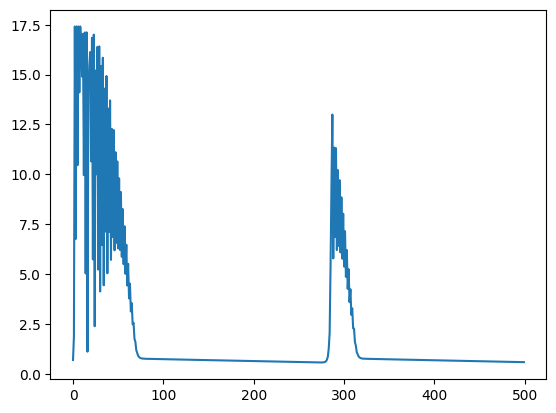

In [23]:
weights,cost = logistic_regression(X_train,y_train,500,0.5)
print('weights = ',weights)
# predicted values
y_ = expit(np.dot(X_test,weights))
print('test cost = ',cost_function(X_test,y_test,y_))

#now lets threshold to obtain the male\female classes
y_th = y_>0.5
score = np.mean(y_test==y_th)
print('score = ',score)
plt.plot(cost)

In [24]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

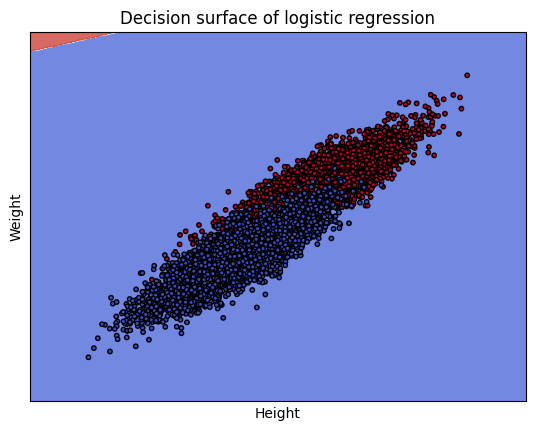

training score:  0.9188059701492537
testing score:  0.9206060606060606
[[-1.83414128  6.1642149 ]]


In [25]:
#Regularization. The parameter C:
#C = float, default=1.0
#Inverse of regularization strength; must be a positive float.
#For no regularization use high C or penalty='none'
#smaller values specify stronger regularization.


clf = LogisticRegression(random_state=0, C=1).fit(X_train, y_train)
fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of logistic regression')
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=10, edgecolors='k')
ax.set_ylabel('Weight')
ax.set_xlabel('Height')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()
print('training score: ',clf.score(X_train,y_train))
print('testing score: ',clf.score(X_test,y_test))
print(clf.coef_)

Note that for higher regularization (lower C), the model becomes more "general", performance decreases and the weights are now both positively correlated

### Note that for higher regularization (lower C), the model becomes more "general", performance decreases and the weights are now both positively correlated